In [2]:
# Import Libraries and Data
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [3]:
# set path
path = r'/Users/lamarosavio/Documents/Instacart Basket Analysis'

In [6]:
# Import most up-to-date project data
instacart = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'orders_products_customers_merged.pkl'))

In [7]:
df = instacart

# Removing PII

In [9]:
df = df.drop(['first_name', 'surname', '_merge'], axis=1)

In [10]:
df.head()

,product_id,product_name,aisle_id,department_id,prices,order_id,user_id,order_number,orders_day_of_week,order_hour_of_day,...,spender_flag,customer_frequency,frequency_flag,gender,state,age,date_joined,n_dependants,marital_status,income
0,1,Chocolate Sandwich Cookies,61,19,5.8,3139998,138,28,6,11,...,Low_spender,8.0,Frequent customer,Male,Minnesota,81,8/1/2019,1,married,49620
1,1,Chocolate Sandwich Cookies,61,19,5.8,1977647,138,30,6,17,...,Low_spender,8.0,Frequent customer,Male,Minnesota,81,8/1/2019,1,married,49620
2,1,Chocolate Sandwich Cookies,61,19,5.8,389851,709,2,0,21,...,Low_spender,7.0,Frequent customer,Female,Vermont,66,6/16/2018,2,married,158302
3,1,Chocolate Sandwich Cookies,61,19,5.8,652770,764,1,3,13,...,Low_spender,9.0,Frequent customer,Female,Wisconsin,40,2/9/2020,3,married,31308
4,1,Chocolate Sandwich Cookies,61,19,5.8,1813452,764,3,4,17,...,Low_spender,9.0,Frequent customer,Female,Wisconsin,40,2/9/2020,3,married,31308


# Creating Regional Segmentations

In [12]:
# creating an empty list to store the region results
region_result = []

# creating the conditions (which state is which region)
for state in df["state"]:
    if state in ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 
                 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 
                 'New Jersey']:
        region_result.append("Northeast")
    elif state in ['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 
                   'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 
                   'Minnesota', 'Iowa', 'Missouri']:
        region_result.append("Midwest")
    elif state in ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 
                   'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 
                   'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 
                   'Oklahoma', 'Texas', 'Arkansas', 'Louisiana']:
        region_result.append("South")
    elif state in ['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 
                   'Arizona', 'New Mexico', 'Alaska', 'Washington', 'Oregon', 
                   'California', 'Hawaii']:
        region_result.append("West")
    else:
        region_result.append("Unknown")

In [13]:
# adding the new region list as a column to the df
df['region'] = region_result

Frequency of Users based on Regions

In [15]:
# Step 1: Distinct on user_id level
df_distinct_user = df.drop_duplicates(subset='user_id')

In [16]:
# Crosstab for user_id level (Region vs Spending Flag)
crosstab_user = pd.crosstab(df_distinct_user['region'], df_distinct_user['spender_flag'], dropna=False)

In [17]:
# Step 2: Distinct on order_id level
df_distinct_order = df.drop_duplicates(subset='order_id')

In [18]:
# Crosstab for order_id level (Region vs Spending Flag)
crosstab_order = pd.crosstab(df_distinct_order['region'], df_distinct_order['spender_flag'], dropna=False)

In [19]:
# Display the crosstabs
print("Crosstab for distinct user_id level:")
print(crosstab_user)

print("\nCrosstab for distinct order_id level:")
print(crosstab_order)

Crosstab for distinct user_id level:
spender_flag  High_spender  Low_spender
region                                 
Midwest               1263        47256
Northeast              883        35505
South                 1817        66920
West                  1394        51171

Crosstab for distinct order_id level:
spender_flag  High_spender  Low_spender
region                                 
Midwest              17057       737218
Northeast            12166       554996
South                24790      1046772
West                 18647       803039


The South has the largest group of high spenders, compared to the Northeast has the smallest. The South also has the largest number of low spenders

# Creating exclusion flag - Users with less than 5 orders

In [22]:
# creating the column holding maximum orders per user

df['max_order'] = df.groupby(['user_id'])['order_number'].transform(np.max)

/var/folders/ds/h59p98rj03vcsx4p3mkf6__80000gn/T/ipykernel_43183/3128420375.py:3: FutureWarning: The provided callable <function max at 0x11c443c40> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df['max_order'] = df.groupby(['user_id'])['order_number'].transform(np.max)


In [23]:
# creating an exclusion flag for low activity users who have less than 5 orders

df.loc[df['max_order'] < 5, 'exclusion_flag'] = 'Low-activity customer'

In [24]:
# creating an exclusion flag for low activity users who 5 or more orders

df.loc[df['max_order'] >= 5, 'exclusion_flag'] = 'Regular-activity customer'

In [25]:
# granulation on order_id level, order quantity (not distinct user_id)

df['exclusion_flag'].value_counts()

exclusion_flag
Regular-activity customer    30964564
Low-activity customer         1440295
Name: count, dtype: int64

In [26]:
# Rename columns for clarity
exclusion_counts = df.groupby('exclusion_flag')['user_id'].nunique().reset_index()
exclusion_counts.columns = ['exclusion_flag', 'unique_user_count']  

In [27]:
# granulation on user_id level, not order quantity 

exclusion_counts

,exclusion_flag,unique_user_count
0,Low-activity customer,43578
1,Regular-activity customer,162631


In [28]:
# filtering out the low-activity users and creating the new dataset 
df_2 = df[df['exclusion_flag'] != 'Low-activity customer']

In [29]:
# check if low-activity customers were filtered out 

df_2['exclusion_flag'].value_counts()

exclusion_flag
Regular-activity customer    30964564
Name: count, dtype: int64

In [30]:
# checking if the numbers are correct 

df_2['user_id'].nunique()

162631

# Creating Profile Variables

Age groups: Young Adults, Adults, Elderly Adults

In [32]:
# age profile is from 18 to 81 

df_2['age'].describe()

count    3.096456e+07
mean     4.946803e+01
std      1.848528e+01
min      1.800000e+01
25%      3.300000e+01
50%      4.900000e+01
75%      6.500000e+01
max      8.100000e+01
Name: age, dtype: float64

In [33]:
# Young Adults: Ages 18 to 34 (inclusive)
df_2.loc[(df_2['age'] >= 18) & (df_2['age'] <= 34), 'age_group'] = 'Young adults'

/var/folders/ds/h59p98rj03vcsx4p3mkf6__80000gn/T/ipykernel_43183/2052288617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.loc[(df_2['age'] >= 18) & (df_2['age'] <= 34), 'age_group'] = 'Young adults'


In [34]:
# Adults: Ages 35 to 64 (inclusive)
df_2.loc[(df_2['age'] >= 35) & (df_2['age'] <= 64), 'age_group'] = 'Adults'

In [35]:
# Elderly Persons: Ages 65 and above
df_2.loc[df_2['age'] >= 65, 'age_group'] = 'Elderly adults'

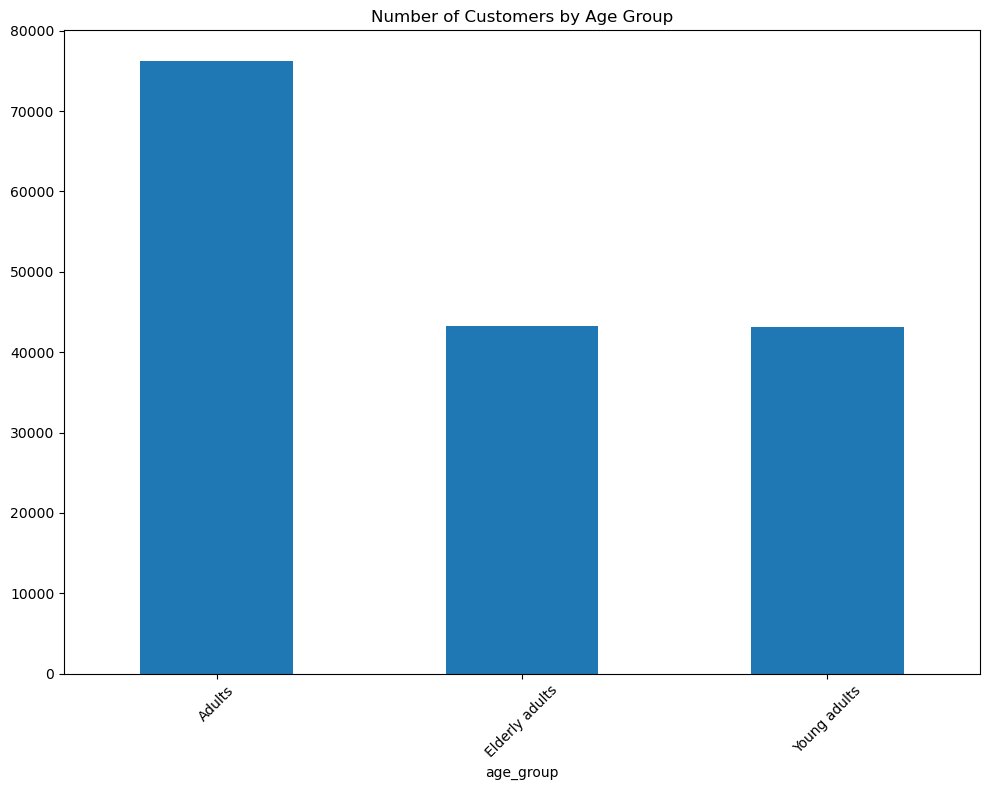

In [36]:
# Count unique user_ids for each age_group
age_group_counts = df_2.groupby('age_group')['user_id'].nunique().sort_index()

# Plot the bar graph with adjusted figure size
plt.figure(figsize=(10, 8))  # Adjust the figure size to make it taller
bar_1 = age_group_counts.plot.bar()
bar_1.set_title('Number of Customers by Age Group')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('unique_customers_by_age_group.png', bbox_inches='tight', dpi=300)
plt.show()

Analysis: Adults (35-64) are the largest data group

# Creating Crosstab Marital Status v Age Group

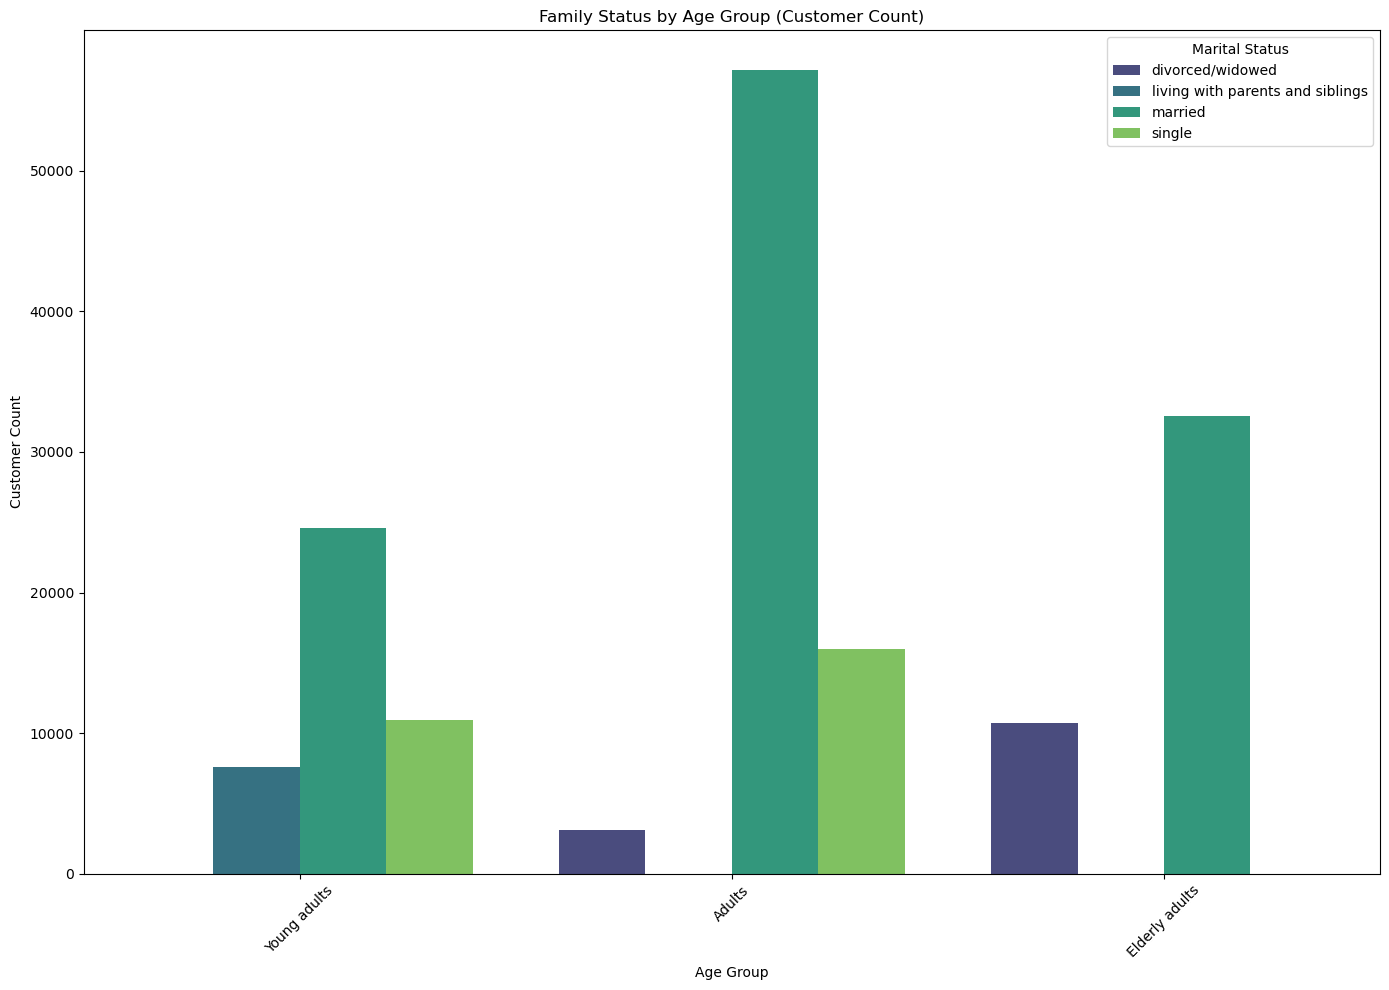

In [39]:
# Step 1: Group by age_group and fam_status, then count unique user_ids
crosstab = df_2.groupby(['age_group', 'marital_status'])['user_id'].nunique().unstack(fill_value=0)

# Step 2: Reset index and melt the crosstab to long-form DataFrame
crosstab_melted = crosstab.reset_index().melt(id_vars='age_group', var_name='marital_status', value_name='count')

# Define the order for age_group: young adults -> adults -> elderly adults
age_order = ['Young adults', 'Adults', 'Elderly adults']

# Set the order for the age_group column using pd.Categorical
crosstab_melted['age_group'] = pd.Categorical(crosstab_melted['age_group'], categories=age_order, ordered=True)

# Step 3: Create a grouped bar chart
plt.figure(figsize=(14, 10))
bar_2 = sns.barplot(x='age_group', y='count', hue='marital_status', data=crosstab_melted, palette='viridis')

# Add title and labels
plt.title('Family Status by Age Group (Customer Count)')
plt.xlabel('Age Group')
plt.ylabel('Customer Count')
plt.legend(title='Marital Status')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.tight_layout()
plt.show()

In [40]:
# exporting the crosstab 

bar_2.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'age_vs_fam.png'))

# Income Groups: Low, Medium, and High Income

In [69]:
df_2['income'].describe()

count    3.096456e+07
mean     9.967587e+04
std      4.314187e+04
min      2.590300e+04
25%      6.729200e+04
50%      9.676500e+04
75%      1.281020e+05
max      5.939010e+05
Name: income, dtype: float64

In [70]:
# creating income buckets based on the 25th and 75th percentiles
# low income

df_2.loc[df_2['income'] < 67289, 'income_group'] = 'Low income'

/var/folders/ds/h59p98rj03vcsx4p3mkf6__80000gn/T/ipykernel_43183/1578009727.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.loc[df_2['income'] < 67289, 'income_group'] = 'Low income'


In [72]:
# medium income 
df_2.loc[(df_2['income'] >= 67289) & (df_2['income'] <= 128101), 'income_group'] = 'Medium income'

In [75]:
# high income
df_2.loc[df_2['income'] > 128101, 'income_group'] = 'High income'

/var/folders/ds/h59p98rj03vcsx4p3mkf6__80000gn/T/ipykernel_43183/1271499452.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['income_group'] = df_2['income_group'].astype(income_order)
/var/folders/ds/h59p98rj03vcsx4p3mkf6__80000gn/T/ipykernel_43183/1271499452.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_group_counts = df_2.groupby('income_group')['user_id'].nunique().sort_index()


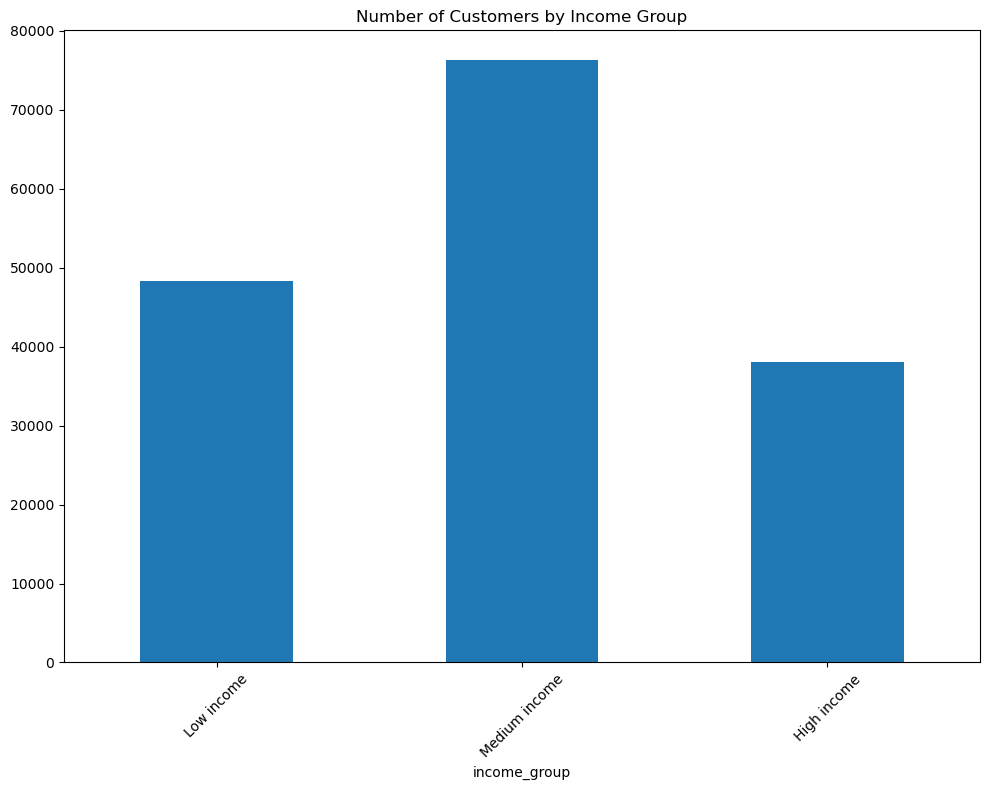

In [77]:
import pandas as pd

# Define the desired order for income groups
income_order = pd.CategoricalDtype(categories=['Low income', 'Medium income', 'High income'], ordered=True)

# Assign the ordered categories to the income_group column
df_2['income_group'] = df_2['income_group'].astype(income_order)

# Count unique user_ids for each income_group
income_group_counts = df_2.groupby('income_group')['user_id'].nunique().sort_index()

# Plot the bar graph with 45-degree x-axis label rotation
plt.figure(figsize=(10, 8))  # Adjust the figure size if needed
bar_3 = income_group_counts.plot.bar()
bar_3.set_title('Number of Customers by Income Group')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('unique_customers_by_income_group.png', bbox_inches='tight', dpi=300)
plt.show()

Analysis: The medium income group makes up the largest group of customers

# Merging Department Names

In [80]:
# importing department dataset

df_dep = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'departments_wrangled.csv'), index_col = False)

In [83]:
# Step 1: Rename 'Unnamed: 0' to 'department_id'
df_dep.rename(columns={'Unnamed: 0': 'department_id'}, inplace=True)

# Step 2: Convert 'department_id' to int64
df_dep['department_id'] = pd.to_numeric(df_dep['department_id'], errors='coerce').astype('int64')

# Step 3: Verify the result
print(df_dep.dtypes)  # Check the data types of all columns
print(df_dep.head())  # Display the first few rows of the DataFrame

department_id     int64
department       object
dtype: object
   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol


In [85]:
df_dep.head(30)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [87]:
df_2.shape

(30964564, 34)

In [89]:
# merging datasets - left table is ords_prods_customers_final (df_2) and I am enriching this table with department info 
df_final = df_2.merge(df_dep, on = 'department_id', how = 'inner', indicator = True)

In [90]:
# checking if merging was successful 

df_final['_merge'].value_counts()

_merge
both          30964564
left_only            0
right_only           0
Name: count, dtype: int64

In [91]:
# dropping _merge column

df_final = df_final.drop(['_merge'], axis=1)

In [92]:
df_final.head()

,product_id,product_name,aisle_id,department_id,prices,order_id,user_id,order_number,orders_day_of_week,order_hour_of_day,...,age,date_joined,n_dependants,marital_status,income,region,exclusion_flag,age_group,income_group,department
0,1,Chocolate Sandwich Cookies,61,19,5.8,3139998,138,28,6,11,...,81,8/1/2019,1,married,49620,Midwest,Regular-activity customer,Elderly adults,Low income,snacks
1,1,Chocolate Sandwich Cookies,61,19,5.8,1977647,138,30,6,17,...,81,8/1/2019,1,married,49620,Midwest,Regular-activity customer,Elderly adults,Low income,snacks
2,1,Chocolate Sandwich Cookies,61,19,5.8,389851,709,2,0,21,...,66,6/16/2018,2,married,158302,Northeast,Regular-activity customer,Elderly adults,High income,snacks
3,1,Chocolate Sandwich Cookies,61,19,5.8,1701441,777,16,1,7,...,51,1/4/2019,2,married,57797,West,Regular-activity customer,Adults,Low income,snacks
4,1,Chocolate Sandwich Cookies,61,19,5.8,1871483,825,3,2,14,...,20,5/8/2019,3,living with parents and siblings,34171,South,Regular-activity customer,Young adults,Low income,snacks


# Creating Number of Dependents group

In [98]:
df_final['n_dependants'].value_counts()

n_dependants
3    7772516
0    7739681
2    7733261
1    7719106
Name: count, dtype: int64

Text(0.5, 1.0, 'Number of Unique Customers by Number of Dependants')

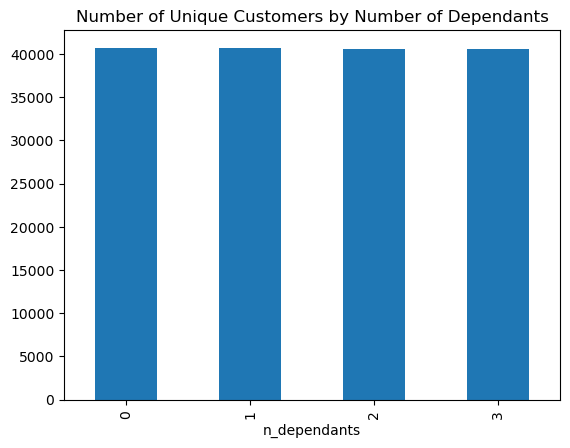

In [100]:
# Calculate the distinct count of user_id for each n_dependants value
dependant_counts = df_final.drop_duplicates(subset='user_id')['n_dependants'].value_counts().sort_index()

# Plot the bar graph
bar_4 = dependant_counts.plot.bar()
bar_4.set_title('Number of Unique Customers by Number of Dependants')

In [101]:
# Adjust layout and figure size if needed
bar_4.figure.set_size_inches(10, 6)  # Adjust the width and height as needed
plt.tight_layout()  # Automatically adjust layout

# Save the figure using the correct reference
bar_4.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'no_kids_bar.png'), bbox_inches='tight', dpi=300)

<Figure size 640x480 with 0 Axes>

In [102]:
# Creating an empty list to store the dependent results
dependants_result = []

# Creating the conditions based on the number of dependents
for n_dependants in df_final['n_dependants']:
    if n_dependants == 0:
        dependants_result.append("no kids")  # no kids
    elif n_dependants == 1:
        dependants_result.append("small family (1 kid)")  # small family
    elif n_dependants in [2, 3]:
        dependants_result.append("big family (2-3 kids)")  # big family with 2 or 3 kids

# Adding the results to the DataFrame as a new column
df_final['dependants_group'] = dependants_result

# Distribution of users based on dependents and marital status

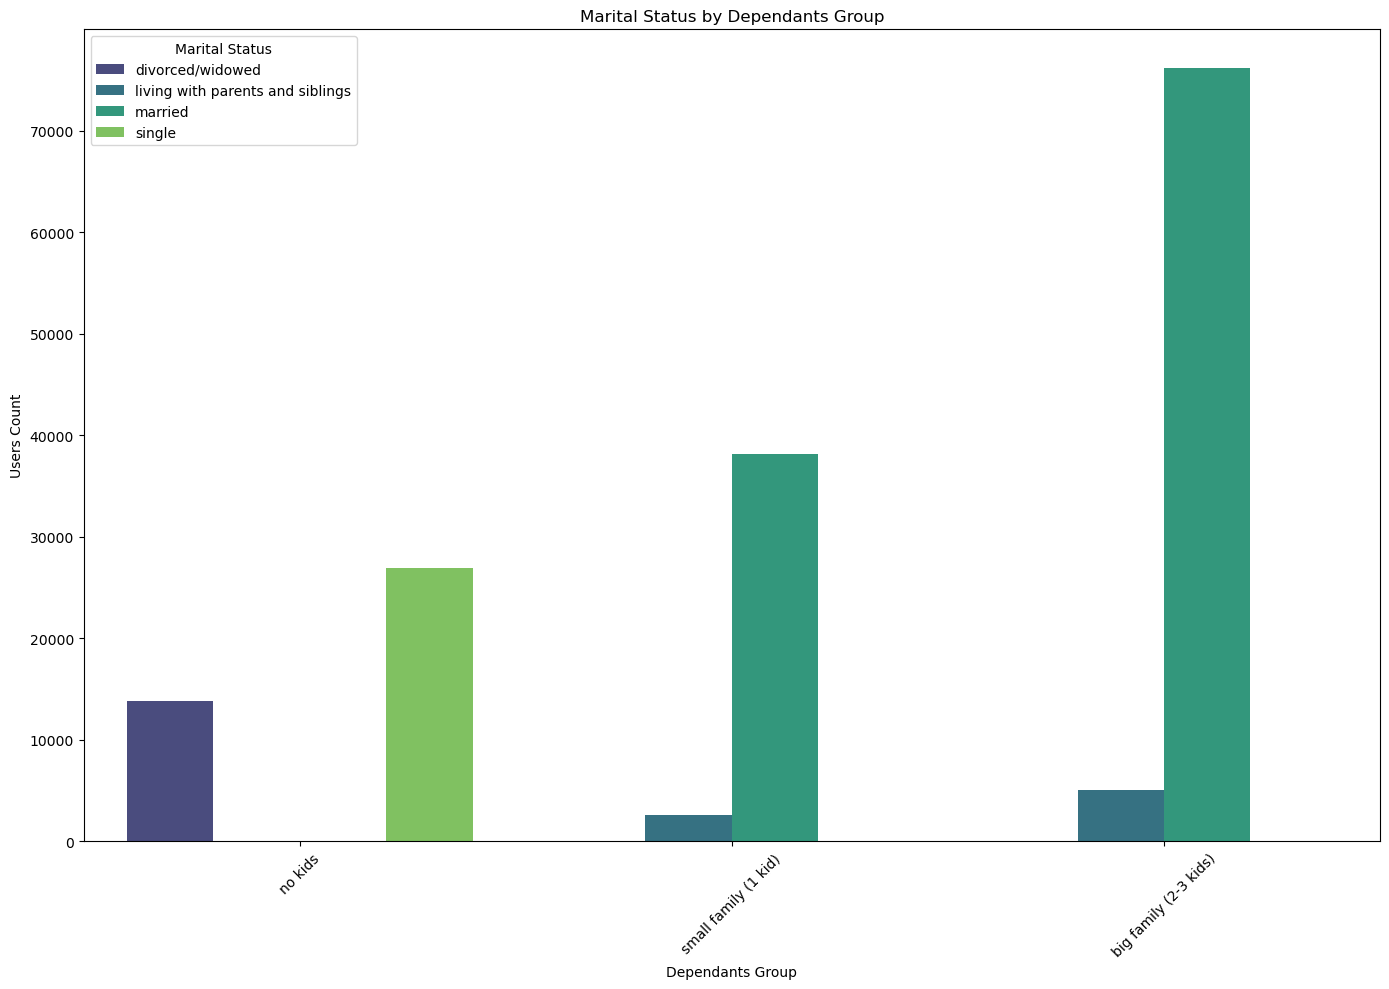

In [105]:
# Create a crosstab for dependants_group and fam_status
crosstab = df_final.groupby(['dependants_group', 'marital_status'])['user_id'].nunique().unstack(fill_value=0)

# Reset index and melt the crosstab to long-form DataFrame for plotting
crosstab_melted = crosstab.reset_index().melt(id_vars='dependants_group', var_name='marital_status', value_name='count')

# Define the order for dependants_group: No Kids -> Small Family -> Big Family
dependants_order = ['no kids', 'small family (1 kid)', 'big family (2-3 kids)']

# Set the order for the dependants_group column using pd.Categorical
crosstab_melted['dependants_group'] = pd.Categorical(crosstab_melted['dependants_group'], categories=dependants_order, ordered=True)

# Step 2: Create a grouped bar chart
plt.figure(figsize=(14, 10))
bar = sns.barplot(x='dependants_group', y='count', hue='marital_status', data=crosstab_melted, palette='viridis')

# Add title and labels
plt.title('Marital Status by Dependants Group')
plt.xlabel('Dependants Group')
plt.ylabel('Users Count')
plt.legend(title='Marital Status')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary

# Save the plot as a file (e.g., PNG or JPG)
plt.tight_layout()  # Ensure layout fits within the figure
plt.savefig('marital_status_dependants_group.png', dpi=300)  # Save with high resolution (300 dpi)

# Show the plot
plt.show()

# Distribution of Quantity of Orders based on dependents group and family status

marital_status         divorced/widowed  living with parents and siblings  \
dependants_group                                                            
big family (2-3 kids)                 0                             96328   
no kids                          261329                                 0   
small family (1 kid)                  0                             49049   

marital_status         married  single  
dependants_group                        
big family (2-3 kids)  1436652       0  
no kids                      0  506425  
small family (1 kid)    714592       0  


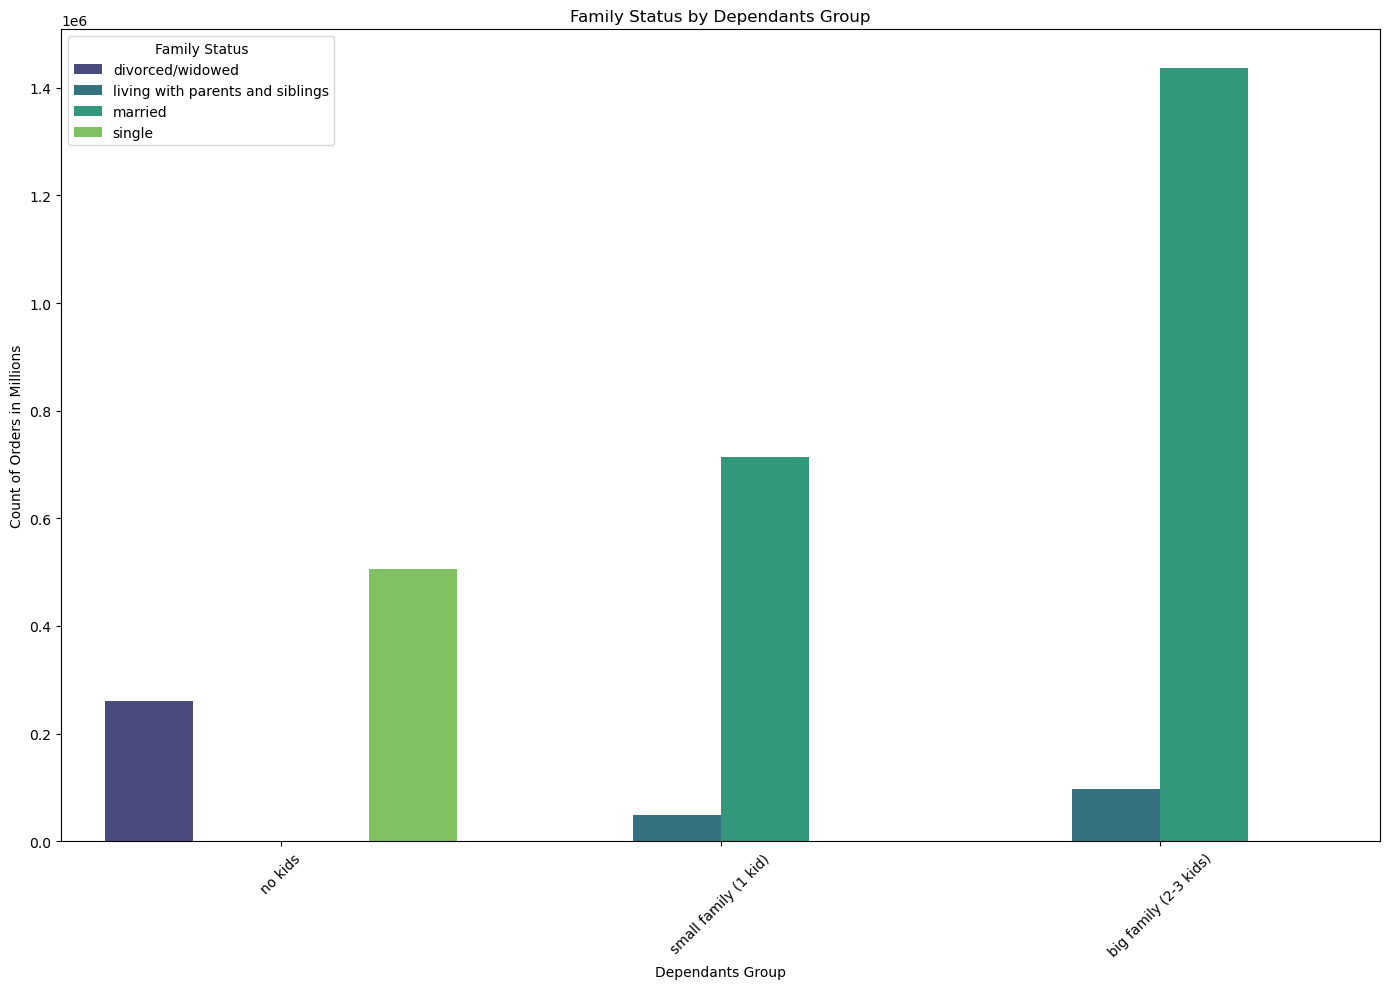

In [109]:
# Create a crosstab for dependants_group and fam_status
crosstab = df_final.groupby(['dependants_group', 'marital_status'])['order_id'].nunique().unstack(fill_value=0)

# Display the crosstab
print(crosstab)

# Reset index and melt the crosstab to long-form DataFrame for plotting
crosstab_melted = crosstab.reset_index().melt(id_vars='dependants_group', var_name='marital_status', value_name='count')

# Define the order for dependants_group: No Kids -> Small Family -> Big Family
dependants_order = ['no kids', 'small family (1 kid)', 'big family (2-3 kids)']

# Set the order for the dependants_group column using pd.Categorical
crosstab_melted['dependants_group'] = pd.Categorical(crosstab_melted['dependants_group'], categories=dependants_order, ordered=True)

# Step 2: Create a grouped bar chart
plt.figure(figsize=(14, 10))
bar = sns.barplot(x='dependants_group', y='count', hue='marital_status', data=crosstab_melted, palette='viridis')

# Add title and labels
plt.title('Family Status by Dependants Group')
plt.xlabel('Dependants Group')
plt.ylabel('Count of Orders in Millions')
plt.legend(title='Family Status')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('marital_status_by_dependants_group.png', bbox_inches='tight', dpi=300)
plt.show()

# Quantity of Orders per day of the week

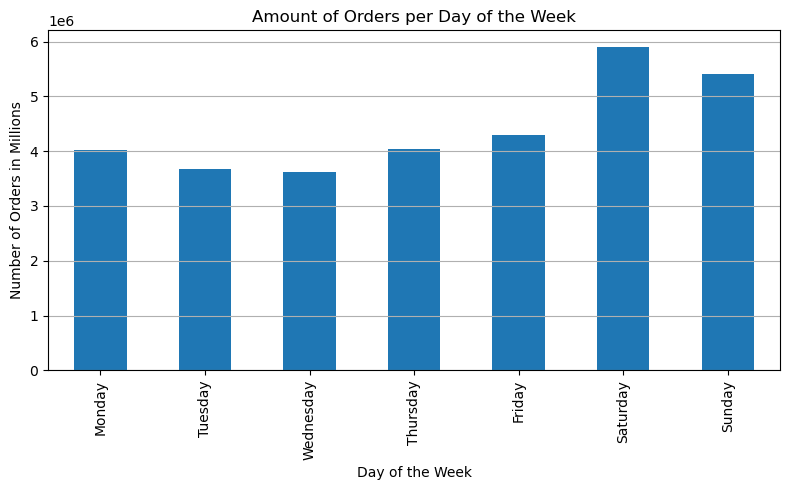

In [111]:
# Create a dictionary to map the day numbers to day names
day_mapping = {
    0: 'Saturday',
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday'
}

# Create a new order for the days of the week starting from Monday
ordered_days = [2, 3, 4, 5, 6, 0, 1]  # Order: Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday

# Calculate the count of orders per day of the week
order_counts = df_final['orders_day_of_week'].value_counts()

# Reorder the counts based on the new order
reordered_counts = order_counts.reindex(ordered_days).fillna(0)  # Fill NaN with 0 for days with no orders

# Plot the count of orders per day of the week
bar_dow = reordered_counts.plot(kind='bar', figsize=(8, 5))

# Set custom x-axis labels using the day mapping
bar_dow.set_xticklabels([day_mapping[day] for day in ordered_days])

# Add a title and labels
plt.title('Amount of Orders per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders in Millions')
plt.grid(axis='y')  # Optional: add horizontal grid lines for readability

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('amount_of_orders_per_day_of_week.png', bbox_inches='tight', dpi=300)
plt.show()

# Quantity of Orders per hour of day

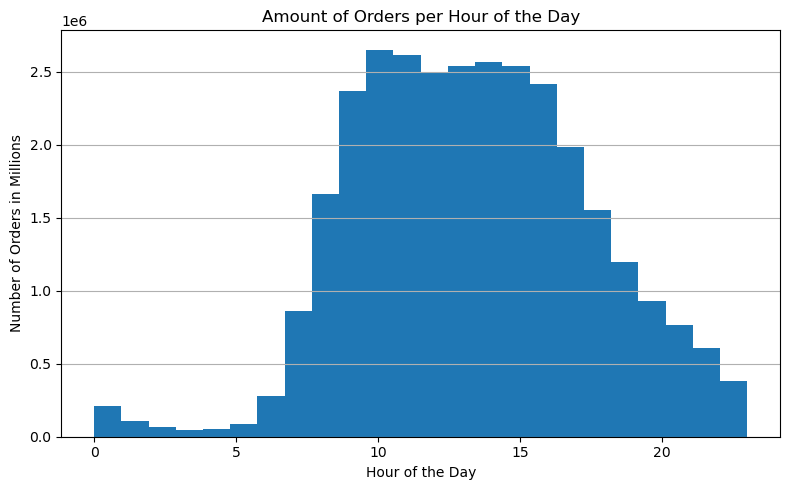

In [113]:
# Plotting the histogram for 'order_hour_of_day' with 24 bins to represent each hour
hist_hour = df_final['order_hour_of_day'].plot.hist(bins=24, figsize=(8, 5))

# Adding a title and axis labels
plt.title('Amount of Orders per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders in Millions')
plt.grid(axis='y')  # Optional: add horizontal grid lines for readability

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('amount_of_orders_per_hour_of_day.png', bbox_inches='tight', dpi=300)
plt.show()

# Creating Weekday and Weekend Group

In [115]:
# List to store the results
day_result = []

for value in df_final["orders_day_of_week"]:
    if value in [0, 1]:  # 0: Saturday, 1: Sunday (Weekend)
        day_result.append("Weekend")
    elif value in [2, 3, 4, 5, 6]:  # 2: Monday, 3: Tuesday, 4: Wednesday, 5: Thursday, 6: Friday (Weekday)
        day_result.append("Weekday")
    else:
        day_result.append("Unknown")  # For any unexpected values

# Adding the new classification to the DataFrame
df_final['day_group'] = day_result

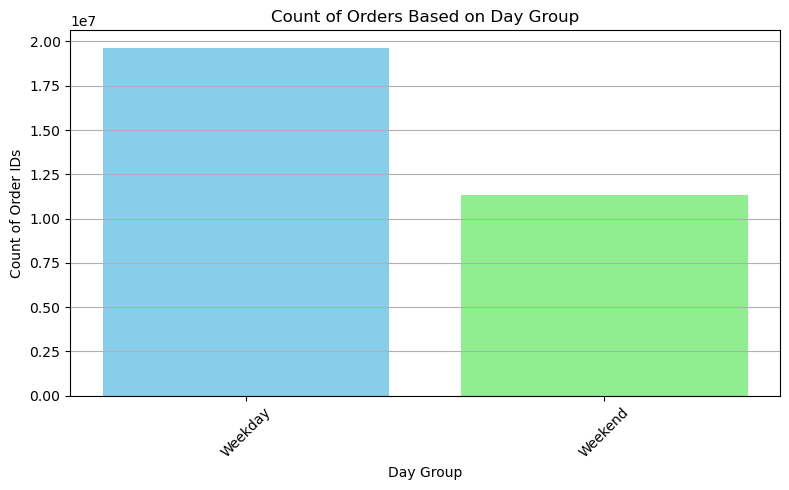

In [116]:
# Group by 'day_group' and count the number of 'order_id's
order_counts = df_final.groupby('day_group')['order_id'].count().reset_index()

# Create a bar chart
plt.figure(figsize=(8, 5))
bar_5 = plt.bar(order_counts['day_group'], order_counts['order_id'], color=['skyblue', 'lightgreen'])
plt.title('Count of Orders Based on Day Group')
plt.xlabel('Day Group')
plt.ylabel('Count of Order IDs')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('count_of_orders_based_on_day_group.png', bbox_inches='tight', dpi=300)
plt.show()

# Creating Hour Groups and Analyze Customer Behaviour during the day

In [119]:
# List to store the results
hour_result = []

for hour in df_final["order_hour_of_day"]:
    if 5 <= hour <= 11:  # Morning: 5 AM - 11 AM
        hour_result.append("Morning")
    elif 12 <= hour <= 16:  # Afternoon: 12 PM - 4 PM
        hour_result.append("Afternoon")
    elif 17 <= hour <= 20:  # Evening: 5 PM - 8 PM
        hour_result.append("Evening")
    else:  # Night: 9 PM - 4 AM
        hour_result.append("Night")

# Adding the new classification to the DataFrame
df_final['hour_group'] = hour_result

/var/folders/ds/h59p98rj03vcsx4p3mkf6__80000gn/T/ipykernel_43183/1391029578.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order_hour_counts = df_final.groupby('hour_group')['order_id'].count().reset_index()


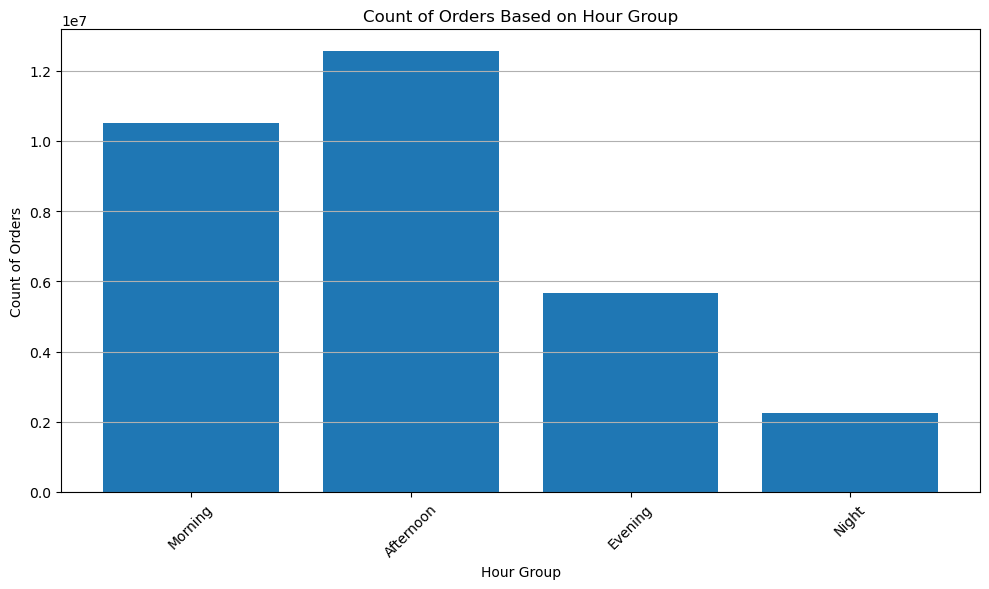

NameError: name 'bar9' is not defined

In [180]:
# Convert 'hour_group' to a categorical type with the specified order
hour_order = ['Morning', 'Afternoon', 'Evening', 'Night']
df_final['hour_group'] = pd.Categorical(df_final['hour_group'], categories=hour_order, ordered=True)

# Group by 'hour_group' and count the number of 'order_id's
order_hour_counts = df_final.groupby('hour_group')['order_id'].count().reset_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(order_hour_counts['hour_group'], order_hour_counts['order_id'])
plt.title('Count of Orders Based on Hour Group')
plt.xlabel('Hour Group')
plt.ylabel('Count of Orders')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('count_of_orders_based_on_hour_group.png', bbox_inches='tight', dpi=300)
plt.show()
# Exporting bar chart

bar9.figure.savefig(os.path.join(path, '04 Analysis','Visualizations','count_orders_based_on_time_of_day.png'))

# Analyze how income/age groups vary in ordering patterns throughout the day

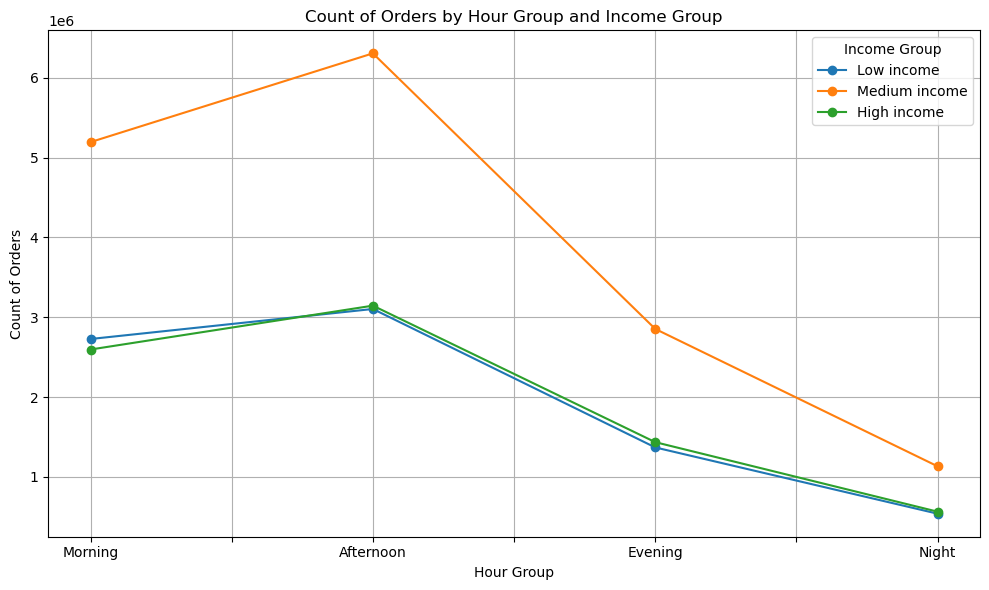

NameError: name 'bar9' is not defined

In [178]:
# Create a crosstab for hour_group and income_group
hour_income_crosstab = pd.crosstab(df_final['hour_group'], df_final['income_group'])

# Sort the index to ensure the x-axis flows in the logical order of the day
hour_income_crosstab = hour_income_crosstab.reindex(['Morning', 'Afternoon', 'Evening', 'Night'])

# Plot the crosstab as a line chart
ax = hour_income_crosstab.plot(kind='line', figsize=(10, 6), marker='o')

# Customize the chart
plt.title('Count of Orders by Hour Group and Income Group')
plt.xlabel('Hour Group')
plt.ylabel('Count of Orders')
plt.xticks(rotation=0)  # Ensure x-axis labels are readable
plt.grid(axis='both')
plt.legend(title='Income Group')
plt.tight_layout()

# Adjust layout and save the figure
plt.savefig('count_of_orders_by_hour_and_income_group.png', bbox_inches='tight', dpi=300)
plt.show()
# Exporting bar chart

bar9.figure.savefig(os.path.join(path, '04 Analysis','Visualizations','count_orders_hour_and_income.png'))

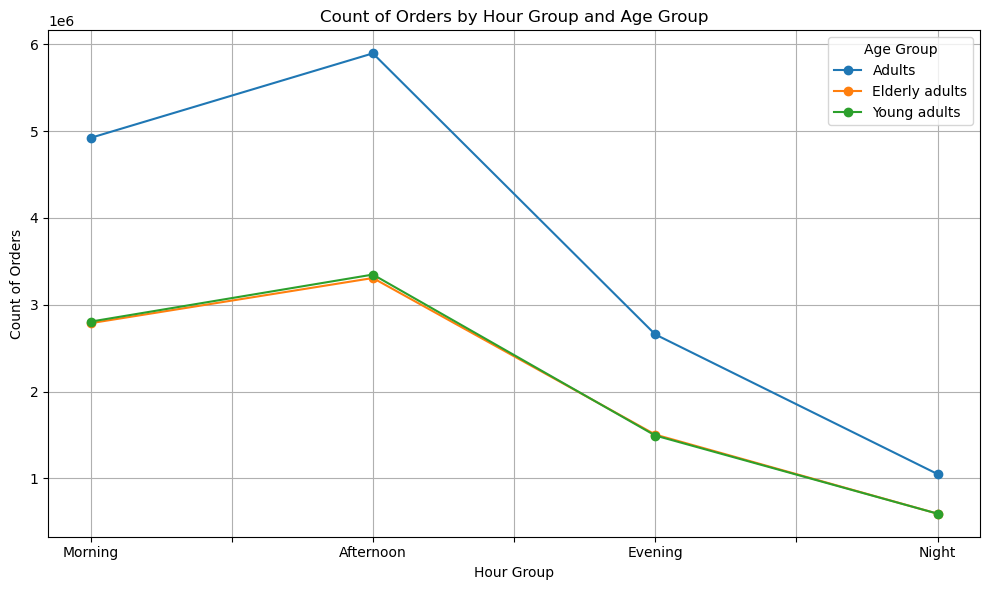

NameError: name 'bar9' is not defined

In [176]:
# Create a crosstab with hour_group on the index and age_group as columns
hour_age_crosstab = pd.crosstab(df_final['hour_group'], df_final['age_group'])

# Reorder the hour groups for a logical flow in the day
hour_age_crosstab = hour_age_crosstab.reindex(['Morning', 'Afternoon', 'Evening', 'Night'])

# Plot the crosstab as a line chart
ax = hour_age_crosstab.plot(kind='line', figsize=(10, 6), marker='o')

# Customize the chart
plt.title('Count of Orders by Hour Group and Age Group')
plt.xlabel('Hour Group')
plt.ylabel('Count of Orders')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal for readability
plt.grid(axis='both')
plt.legend(title='Age Group')  # Set legend title to Age Group
plt.tight_layout()

# Adjust layout and save the figure
plt.savefig('count_of_orders_by_hour_and_age_group.png', bbox_inches='tight', dpi=300)
plt.show()
# Exporting bar chart

bar9.figure.savefig(os.path.join(path, '04 Analysis','Visualizations','count_orders_by_hour_and_age.png'))

# Analyze Distribution of price ranges and frequency

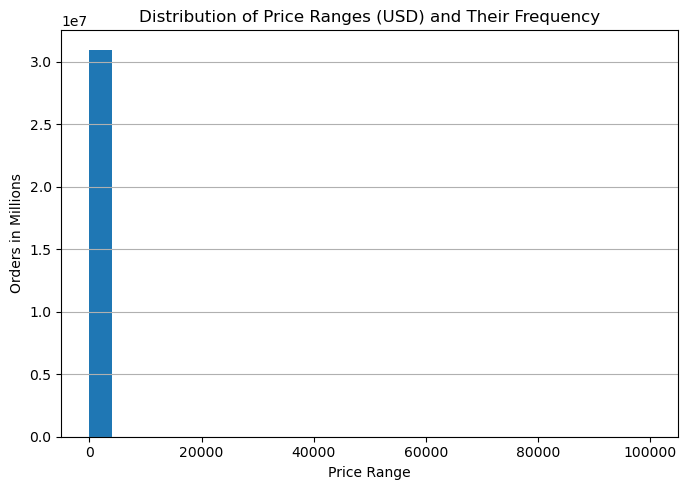

In [125]:
# Plotting the histogram for the 'prices' column
hist_o = df_final['prices'].plot.hist(bins=25, figsize=(7, 5))

# Adding a title and labels
plt.title('Distribution of Price Ranges (USD) and Their Frequency')
plt.xlabel('Price Range')
plt.ylabel('Orders in Millions')
plt.grid(axis='y')  # Optional: add grid lines for better readability

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('distribution_of_price_ranges.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

# Analyze Departments and Order Quantity

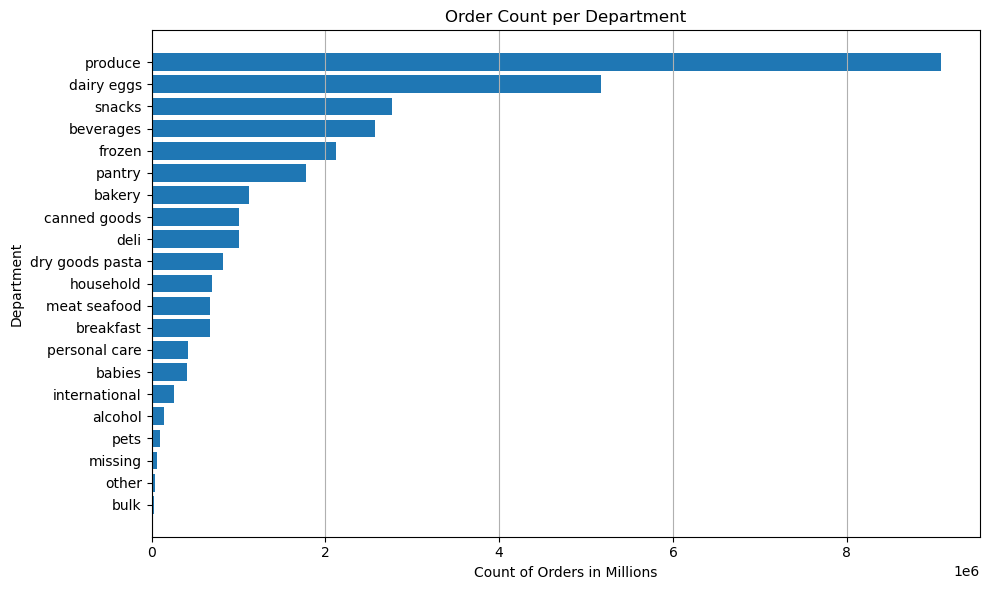

AttributeError: 'DataFrame' object has no attribute 'figure'

In [184]:
# Group by 'department' and count the number of 'order_id's
dept_order_counts = df_final.groupby('department')['order_id'].count().reset_index()

# Sort the counts in descending order
dept_order_counts = dept_order_counts.sort_values(by='order_id', ascending=True)

# Plot the counts as a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(dept_order_counts['department'], dept_order_counts['order_id'])

# Add a title and labels
plt.title('Order Count per Department')
plt.ylabel('Department')  # y-axis label since the bars are horizontal
plt.xlabel('Count of Orders in Millions')
plt.grid(axis='x')  # Add grid lines on the x-axis for better readability

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('order_count_per_department.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()
# Exporting bar chart

dept_order_counts.figure.savefig(os.path.join(path, '04 Analysis','Visualizations','count_orders_based_on_department.png'))

# Spenderflag & Customer Count

/var/folders/ds/h59p98rj03vcsx4p3mkf6__80000gn/T/ipykernel_43183/1833997149.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spending_vs_income_group_user = df_final.groupby(['spender_flag', 'income_group'])['user_id'].nunique().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

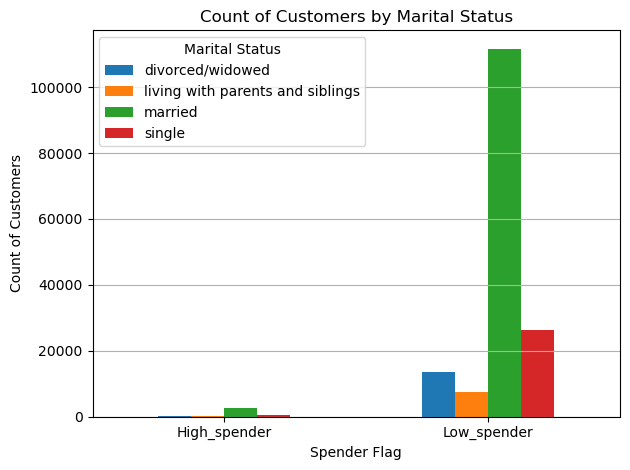

<Figure size 1000x600 with 0 Axes>

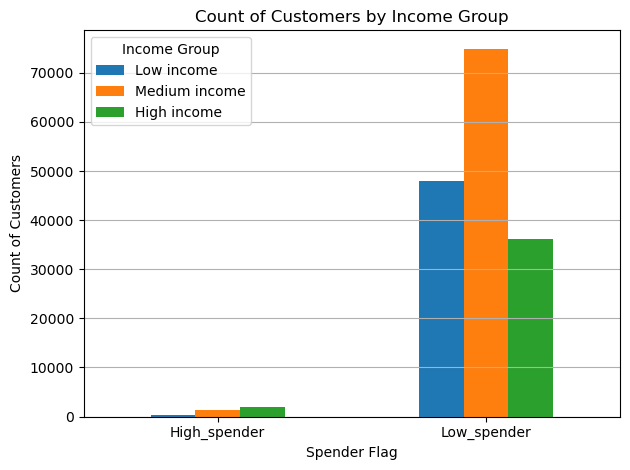

<Figure size 1000x600 with 0 Axes>

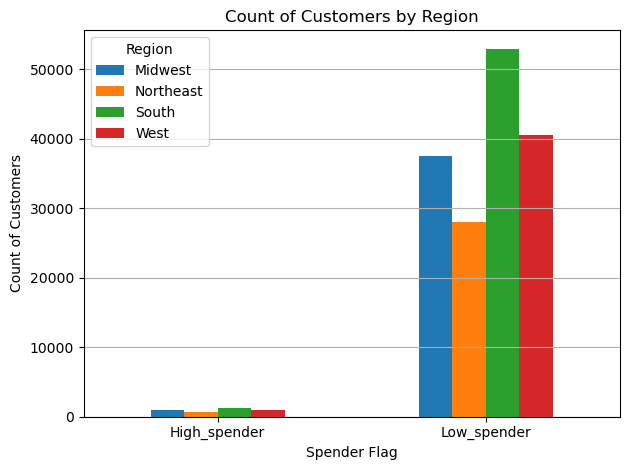

<Figure size 1000x600 with 0 Axes>

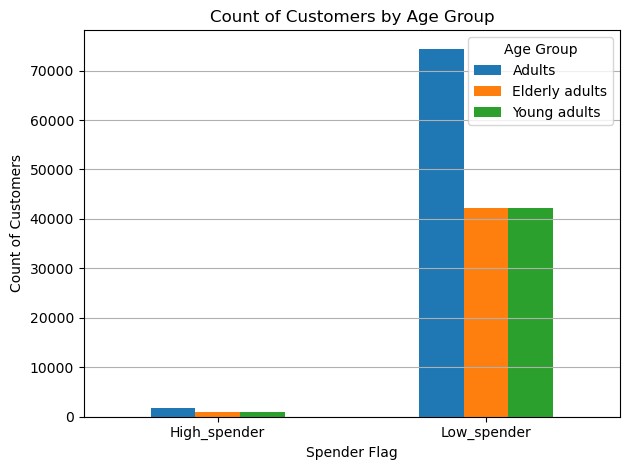

In [143]:
# Grouping by 'spending_flag' and 'fam_status' to get distinct user counts
spending_vs_fam_status_user = df_final.groupby(['spender_flag', 'marital_status'])['user_id'].nunique().unstack(fill_value=0)
spending_vs_income_group_user = df_final.groupby(['spender_flag', 'income_group'])['user_id'].nunique().unstack(fill_value=0)
spending_vs_region_user = df_final.groupby(['spender_flag', 'region'])['user_id'].nunique().unstack(fill_value=0)
spending_vs_age_group_user = df_final.groupby(['spender_flag', 'age_group'])['user_id'].nunique().unstack(fill_value=0)

# Plotting distinct user counts by family status
plt.figure(figsize=(10, 6))
spending_vs_fam_status_user.plot(kind='bar', stacked=False)
plt.title('Count of Customers by Marital Status')
plt.xlabel('Spender Flag')
plt.ylabel('Count of Customers')
plt.xticks(rotation=0)
plt.legend(title='Marital Status')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('count_customers_by_marital_status.png', bbox_inches='tight', dpi=300)
plt.show()

# Plotting distinct user counts by income group
plt.figure(figsize=(10, 6))
spending_vs_income_group_user.plot(kind='bar', stacked=False)
plt.title('Count of Customers by Income Group')
plt.xlabel('Spender Flag')
plt.ylabel('Count of Customers')
plt.xticks(rotation=0)
plt.legend(title='Income Group')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('count_customers_by_income_group.png', bbox_inches='tight', dpi=300)
plt.show()

# Plotting distinct user counts by region
plt.figure(figsize=(10, 6))
spending_vs_region_user.plot(kind='bar', stacked=False)
plt.title('Count of Customers by Region')
plt.xlabel('Spender Flag')
plt.ylabel('Count of Customers')
plt.xticks(rotation=0)
plt.legend(title='Region')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('count_customers_by_region.png', bbox_inches='tight', dpi=300)
plt.show()

# Plotting distinct user counts by age group
plt.figure(figsize=(10, 6))
spending_vs_age_group_user.plot(kind='bar', stacked=False)
plt.title('Count of Customers by Age Group')
plt.xlabel('Spender Flag')
plt.ylabel('Count of Customers')
plt.xticks(rotation=0)
plt.legend(title='Age Group')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('count_customers_by_age_group.png', bbox_inches='tight', dpi=300)
plt.show()

# Spender flag & Order count

/var/folders/ds/h59p98rj03vcsx4p3mkf6__80000gn/T/ipykernel_43183/1545484628.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spending_vs_income_group_order = df_final.groupby(['spender_flag', 'income_group'])['order_id'].count().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

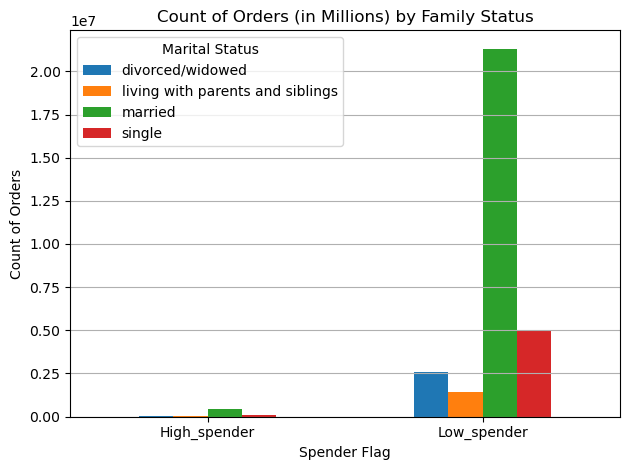

<Figure size 1000x600 with 0 Axes>

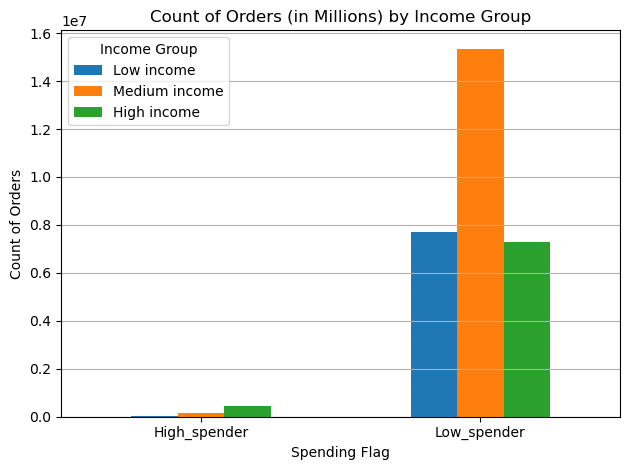

<Figure size 1000x600 with 0 Axes>

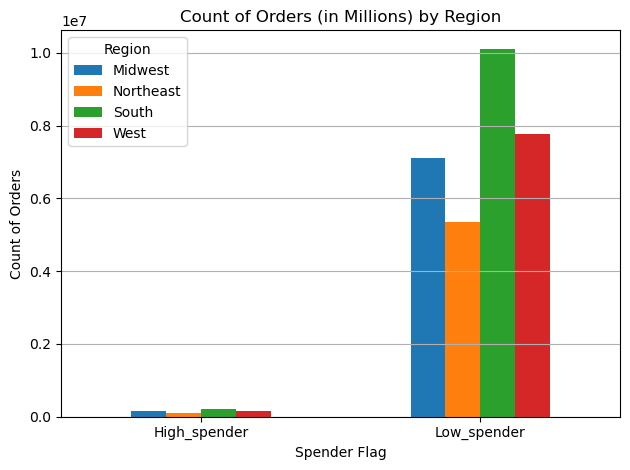

<Figure size 1000x600 with 0 Axes>

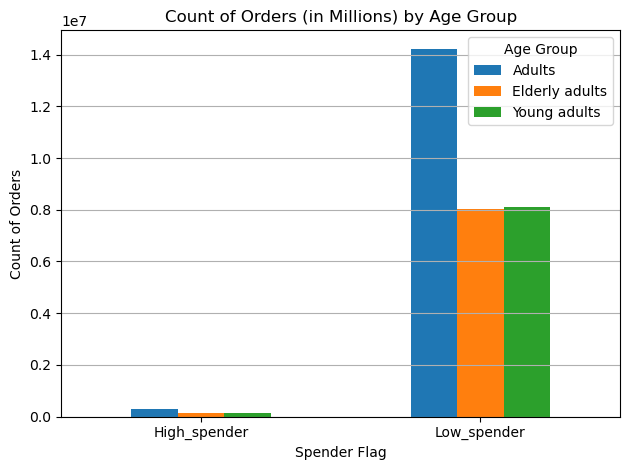

NameError: name 'bar9' is not defined

In [172]:
# Grouping by 'spending_flag' and 'fam_status' to get order counts
spending_vs_fam_status_order = df_final.groupby(['spender_flag', 'marital_status'])['order_id'].count().unstack(fill_value=0)
spending_vs_income_group_order = df_final.groupby(['spender_flag', 'income_group'])['order_id'].count().unstack(fill_value=0)
spending_vs_region_order = df_final.groupby(['spender_flag', 'region'])['order_id'].count().unstack(fill_value=0)
spending_vs_age_group_order = df_final.groupby(['spender_flag', 'age_group'])['order_id'].count().unstack(fill_value=0)

# Plotting order counts by marital status
plt.figure(figsize=(10, 6))
spending_vs_fam_status_order.plot(kind='bar', stacked=False)
plt.title('Count of Orders (in Millions) by Family Status')
plt.xlabel('Spender Flag')
plt.ylabel('Count of Orders')
plt.xticks(rotation=0)
plt.legend(title='Marital Status')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('count_orders_by_family_status.png', bbox_inches='tight', dpi=300)
plt.show()

# Plotting order counts by income group
plt.figure(figsize=(10, 6))
spending_vs_income_group_order.plot(kind='bar', stacked=False)
plt.title('Count of Orders (in Millions) by Income Group')
plt.xlabel('Spending Flag')
plt.ylabel('Count of Orders')
plt.xticks(rotation=0)
plt.legend(title='Income Group')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('count_orders_by_income_group.png', bbox_inches='tight', dpi=300)
plt.show()

# Plotting order counts by region
plt.figure(figsize=(10, 6))
spending_vs_region_order.plot(kind='bar', stacked=False)
plt.title('Count of Orders (in Millions) by Region')
plt.xlabel('Spender Flag')
plt.ylabel('Count of Orders')
plt.xticks(rotation=0)
plt.legend(title='Region')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('count_orders_by_region.png', bbox_inches='tight', dpi=300)
plt.show()

# Plotting order counts by age group
plt.figure(figsize=(10, 6))
spending_vs_age_group_order.plot(kind='bar', stacked=False)
plt.title('Count of Orders (in Millions) by Age Group')
plt.xlabel('Spender Flag')
plt.ylabel('Count of Orders')
plt.xticks(rotation=0)
plt.legend(title='Age Group')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('count_orders_by_age_group.png', bbox_inches='tight', dpi=300)
plt.show()
# Exporting bar chart

bar9.figure.savefig(os.path.join(path, '04 Analysis','Visualizations','spender_flag_count_order.png'))

# Loyalty Flag & Customer Count

In [ ]:
# Crosstabs for 'loyalty_flag' counting unique user_id
loyalty_vs_fam_status = df_final.groupby(['loyalty_flag', 'marital_status'])['user_id'].nunique().unstack(fill_value=0)
loyalty_vs_income_group = df_final.groupby(['loyalty_flag', 'income_group'])['user_id'].nunique().unstack(fill_value=0)
loyalty_vs_region = df_final.groupby(['loyalty_flag', 'region'])['user_id'].nunique().unstack(fill_value=0)
loyalty_vs_age_group = df_final.groupby(['loyalty_flag', 'age_group'])['user_id'].nunique().unstack(fill_value=0)

# Plotting the crosstab for Family Status
plt.figure(figsize=(10, 6))
loyalty_vs_fam_status.plot(kind='bar', stacked=False)
plt.title('Distinct Count of Customers by Family Status')
plt.xlabel('Loyalty Flag')
plt.ylabel('Distinct Count of Customers')
plt.xticks(rotation=0)
plt.legend(title='Marital Status')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('loyalty_vs_marital_status_customer.png', bbox_inches='tight', dpi=300)
plt.show()

# Plotting the crosstab for Income Group
plt.figure(figsize=(10, 6))
loyalty_vs_income_group.plot(kind='bar', stacked=False)
plt.title('Distinct Count of Customers by Income Group')
plt.xlabel('Loyalty Flag')
plt.ylabel('Distinct Count of Customers')
plt.xticks(rotation=0)
plt.legend(title='Income Group')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('loyalty_vs_income_group_customer.png', bbox_inches='tight', dpi=300)
plt.show()

# Plotting the crosstab for Region
plt.figure(figsize=(10, 6))
loyalty_vs_region.plot(kind='bar', stacked=False)
plt.title('Distinct Count of Customers by Region')
plt.xlabel('Loyalty Flag')
plt.ylabel('Distinct Count of Customers')
plt.xticks(rotation=0)
plt.legend(title='Region')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('loyalty_vs_region_customer.png', bbox_inches='tight', dpi=300)
plt.show()

# Plotting the crosstab for Age Group
plt.figure(figsize=(10, 6))
loyalty_vs_age_group.plot(kind='bar', stacked=False)
plt.title('Distinct Count of Customers by Age Group')
plt.xlabel('Loyalty Flag')
plt.ylabel('Distinct Count of Customers')
plt.xticks(rotation=0)
plt.legend(title='Age Group')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('loyalty_vs_age_group_customer.png', bbox_inches='tight', dpi=300)
plt.show()
# Exporting bar chart

bar9.figure.savefig(os.path.join(path, '04 Analysis','Visualizations','count_cust_marital_status.png'))

# Loyalty Flag & Order Count

/var/folders/ds/h59p98rj03vcsx4p3mkf6__80000gn/T/ipykernel_43183/4072842608.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loyalty_vs_income_group_orders = df_final.groupby(['loyalty_flag', 'income_group'])['order_id'].nunique().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

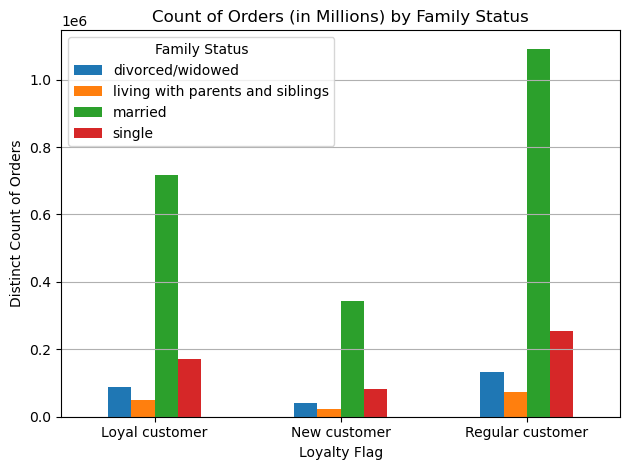

<Figure size 1000x600 with 0 Axes>

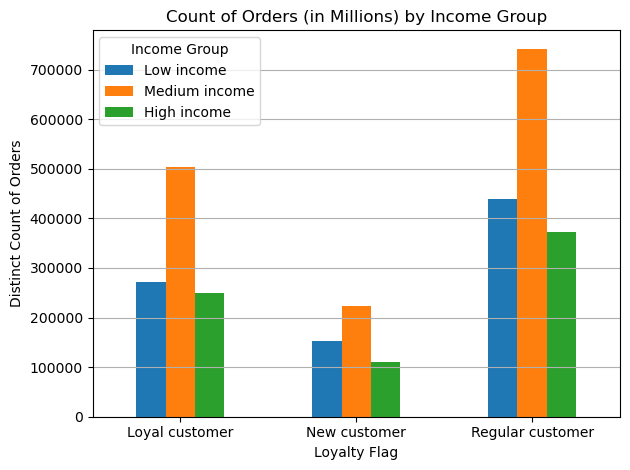

<Figure size 1000x600 with 0 Axes>

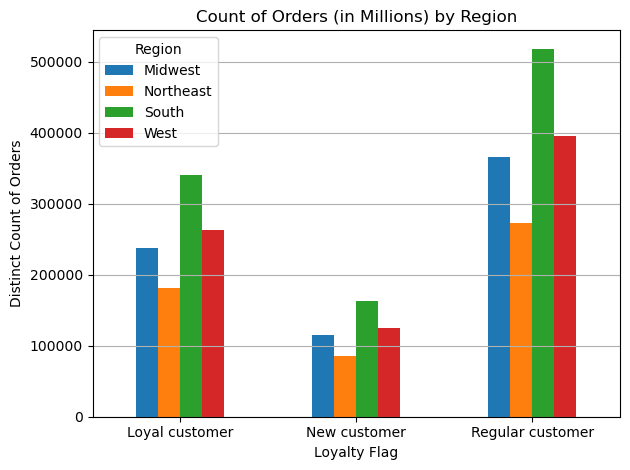

<Figure size 1000x600 with 0 Axes>

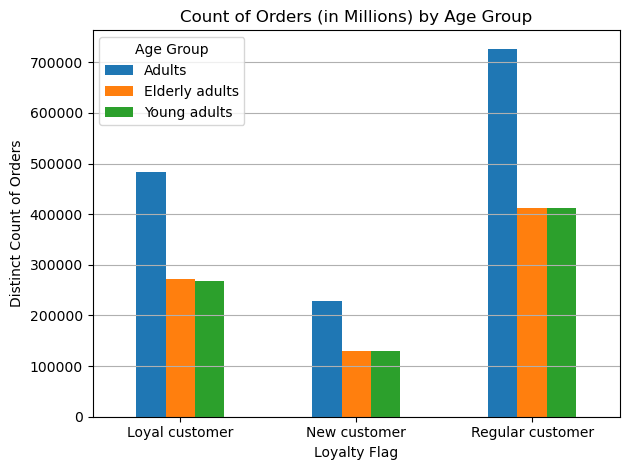

NameError: name 'bar9' is not defined

In [169]:
# Crosstabs for 'loyalty_flag' counting unique order_id
loyalty_vs_fam_status_orders = df_final.groupby(['loyalty_flag', 'marital_status'])['order_id'].nunique().unstack(fill_value=0)
loyalty_vs_income_group_orders = df_final.groupby(['loyalty_flag', 'income_group'])['order_id'].nunique().unstack(fill_value=0)
loyalty_vs_region_orders = df_final.groupby(['loyalty_flag', 'region'])['order_id'].nunique().unstack(fill_value=0)
loyalty_vs_age_group_orders = df_final.groupby(['loyalty_flag', 'age_group'])['order_id'].nunique().unstack(fill_value=0)

# Plotting the crosstab for Family Status (Orders)
plt.figure(figsize=(10, 6))
loyalty_vs_fam_status_orders.plot(kind='bar', stacked=False)
plt.title('Count of Orders (in Millions) by Family Status')
plt.xlabel('Loyalty Flag')
plt.ylabel('Distinct Count of Orders')
plt.xticks(rotation=0)
plt.legend(title='Family Status')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('loyalty_vs_fam_status_orders.png', bbox_inches='tight', dpi=300)
plt.show()

# Plotting the crosstab for Income Group (Orders)
plt.figure(figsize=(10, 6))
loyalty_vs_income_group_orders.plot(kind='bar', stacked=False)
plt.title('Count of Orders (in Millions) by Income Group')
plt.xlabel('Loyalty Flag')
plt.ylabel('Distinct Count of Orders')
plt.xticks(rotation=0)
plt.legend(title='Income Group')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('loyalty_vs_income_group_orders.png', bbox_inches='tight', dpi=300)
plt.show()

# Plotting the crosstab for Region (Orders)
plt.figure(figsize=(10, 6))
loyalty_vs_region_orders.plot(kind='bar', stacked=False)
plt.title('Count of Orders (in Millions) by Region')
plt.xlabel('Loyalty Flag')
plt.ylabel('Distinct Count of Orders')
plt.xticks(rotation=0)
plt.legend(title='Region')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('loyalty_vs_region_orders.png', bbox_inches='tight', dpi=300)
plt.show()

# Plotting the crosstab for Age Group (Orders)
plt.figure(figsize=(10, 6))
loyalty_vs_age_group_orders.plot(kind='bar', stacked=False)
plt.title('Count of Orders (in Millions) by Age Group')
plt.xlabel('Loyalty Flag')
plt.ylabel('Distinct Count of Orders')
plt.xticks(rotation=0)
plt.legend(title='Age Group')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('loyalty_vs_age_group_orders.png', bbox_inches='tight', dpi=300)
plt.show()
# Exporting bar chart

bar9.figure.savefig(os.path.join(path, '04 Analysis','Visualizations','loyaltyflag_order_count.png'))

# Order Behaviour by Department & Customer Groups

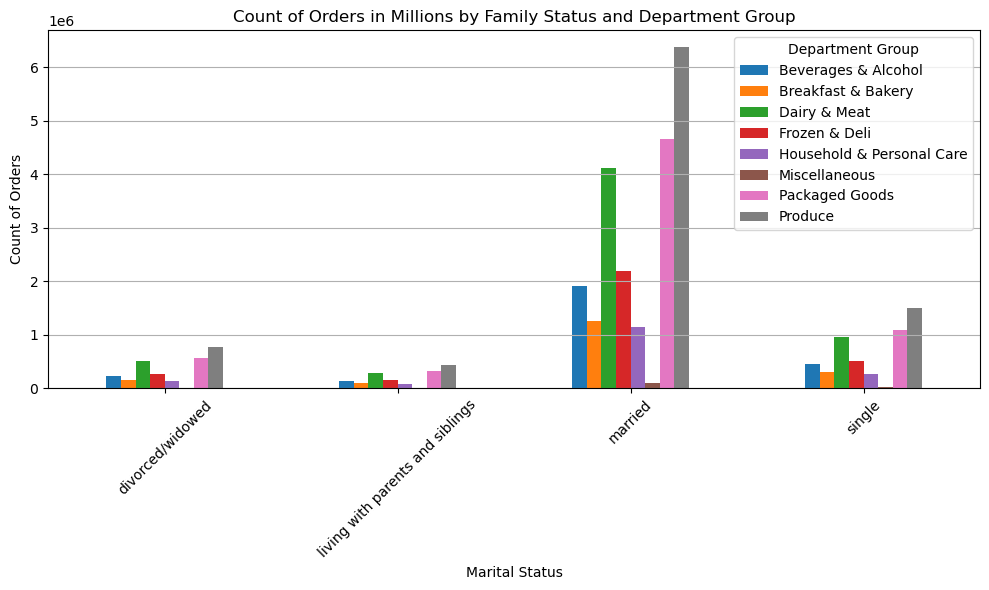

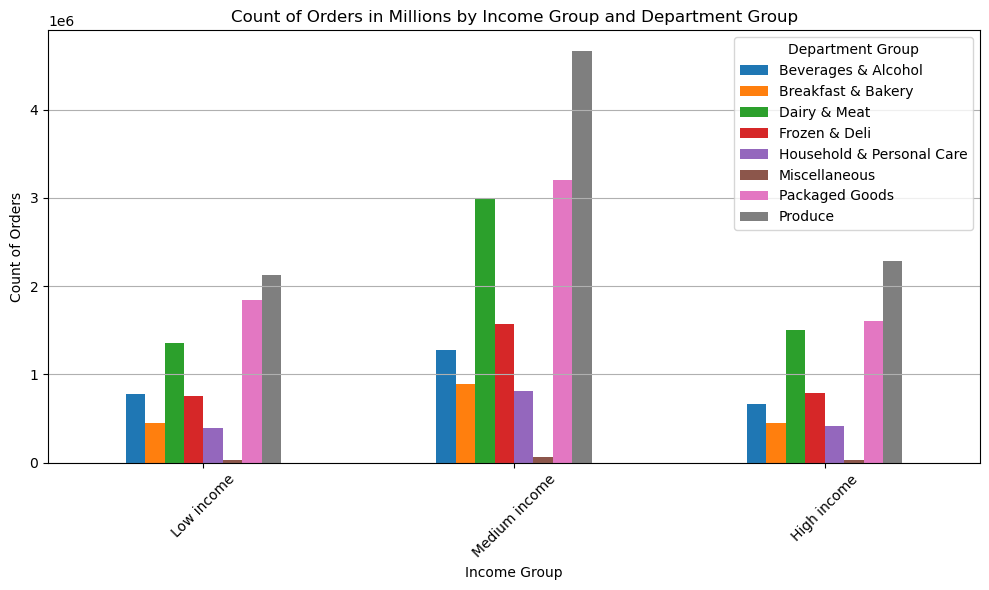

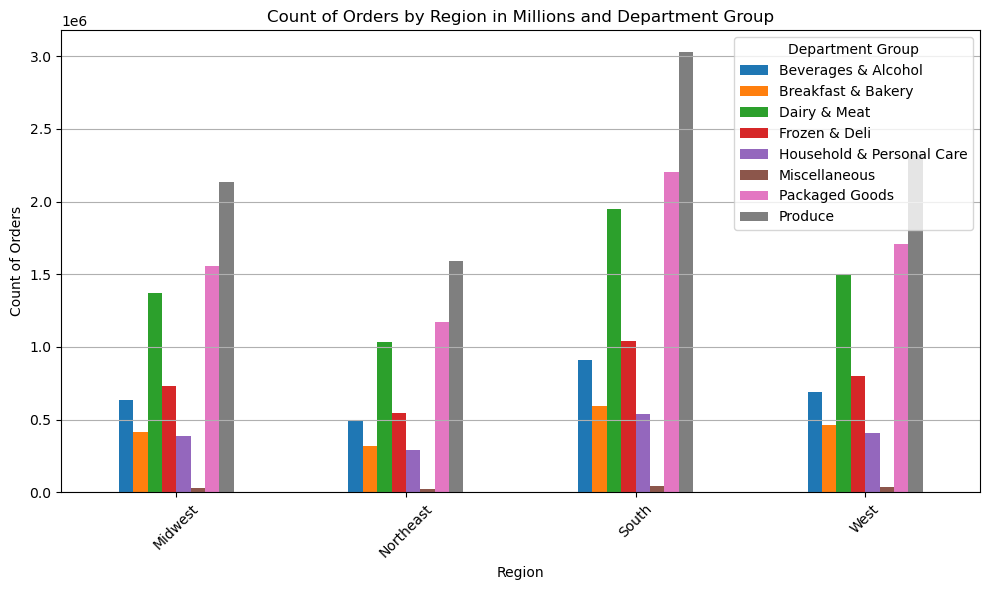

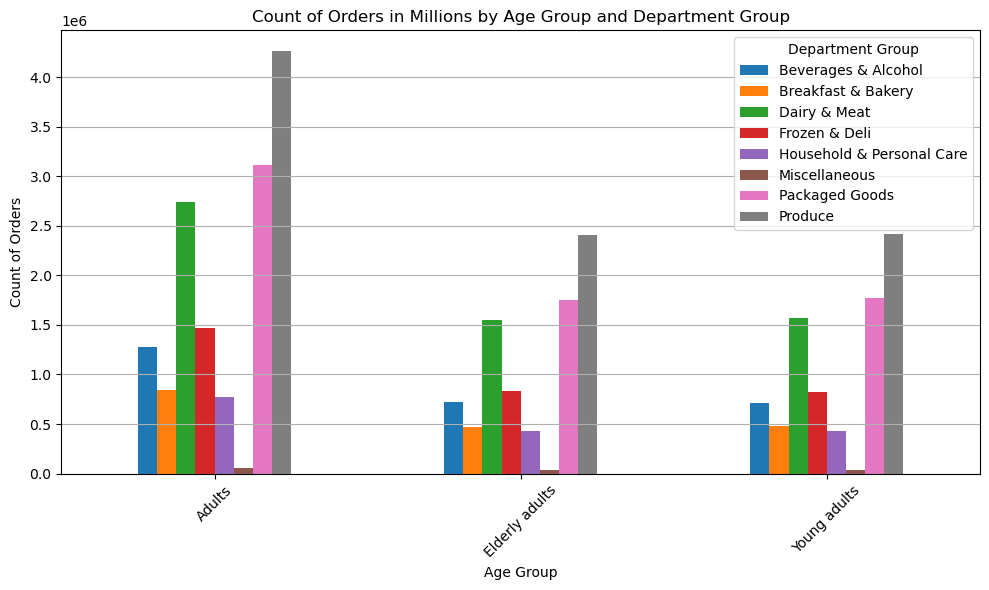

NameError: name 'bar9' is not defined

In [167]:
# Define a function to group departments into more specific categories
def group_departments(department):
    if department in ['dairy eggs', 'meat seafood']:
        return 'Dairy & Meat'
    elif department in ['breakfast', 'bakery']:
        return 'Breakfast & Bakery'
    elif department in ['frozen', 'deli']:
        return 'Frozen & Deli'
    elif department == 'produce':
        return 'Produce'
    elif department in ['beverages', 'alcohol']:
        return 'Beverages & Alcohol'
    elif department in ['canned goods', 'pantry', 'dry goods pasta', 'snacks', 'international']:
        return 'Packaged Goods'
    elif department in ['personal care', 'household', 'pets', 'babies']:
        return 'Household & Personal Care'
    else:
        return 'Miscellaneous'

# Apply the updated grouping function to the 'department' column
df_final['dept_group'] = df_final['department'].apply(group_departments)

# Crosstabs for the updated grouped departments vs family status, income group, region, and age group
# Based on 'order_id', not 'user_id'
dept_group_vs_fam_status = pd.crosstab(df_final['dept_group'], df_final['marital_status'], values=df_final['order_id'], aggfunc='count')
dept_group_vs_income_group = pd.crosstab(df_final['dept_group'], df_final['income_group'], values=df_final['order_id'], aggfunc='count')
dept_group_vs_region = pd.crosstab(df_final['dept_group'], df_final['region'], values=df_final['order_id'], aggfunc='count')
dept_group_vs_age_group = pd.crosstab(df_final['dept_group'], df_final['age_group'], values=df_final['order_id'], aggfunc='count')

# Define a list of tuples containing the cross-tabulation results and plot titles
plots = [
    (dept_group_vs_fam_status, 'Marital Status', 'Count of Orders in Millions by Family Status and Department Group', 'dept_group_vs_fam_status.png'),
    (dept_group_vs_income_group, 'Income Group', 'Count of Orders in Millions by Income Group and Department Group', 'dept_group_vs_income_group.png'),
    (dept_group_vs_region, 'Region', 'Count of Orders by Region in Millions and Department Group', 'dept_group_vs_region.png'),
    (dept_group_vs_age_group, 'Age Group', 'Count of Orders in Millions by Age Group and Department Group', 'dept_group_vs_age_group.png')
]

# Iterate over the list and create plots for each cross-tabulation
for crosstab, legend_title, title, filename in plots:
    plt.figure(figsize=(10, 6))
    
    # Plot the crosstab data with departments on the x-axis
    crosstab.T.plot(kind='bar', stacked=False, ax=plt.gca())
    
    plt.title(title)
    plt.xlabel(legend_title)
    plt.ylabel('Count of Orders')
    plt.xticks(rotation=45)
    plt.legend(title='Department Group')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()
    # Exporting bar chart

bar9.figure.savefig(os.path.join(path, '04 Analysis','Visualizations','count_orders_mar_status_dept.png'))

# Regional Specifics

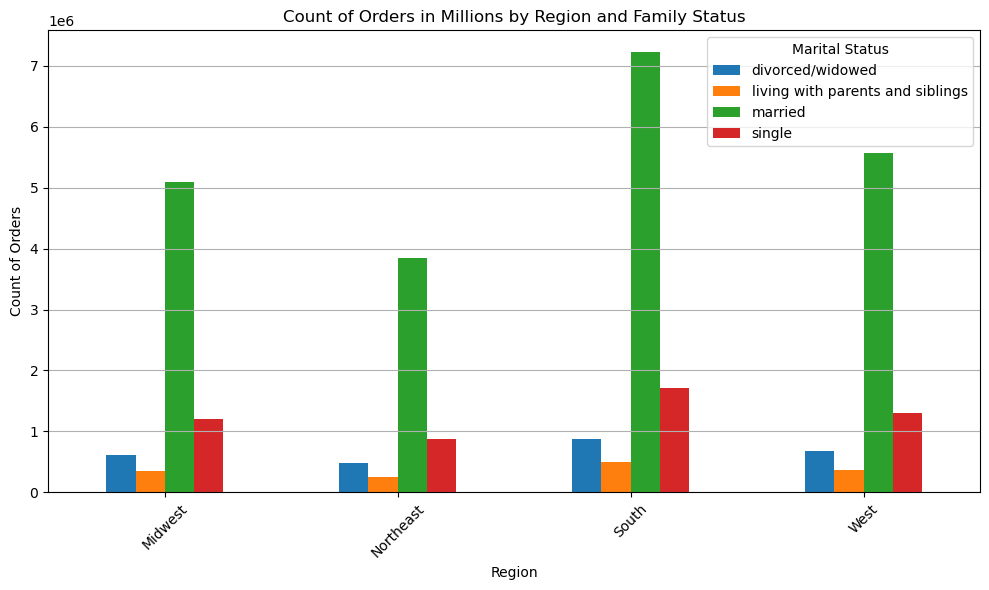

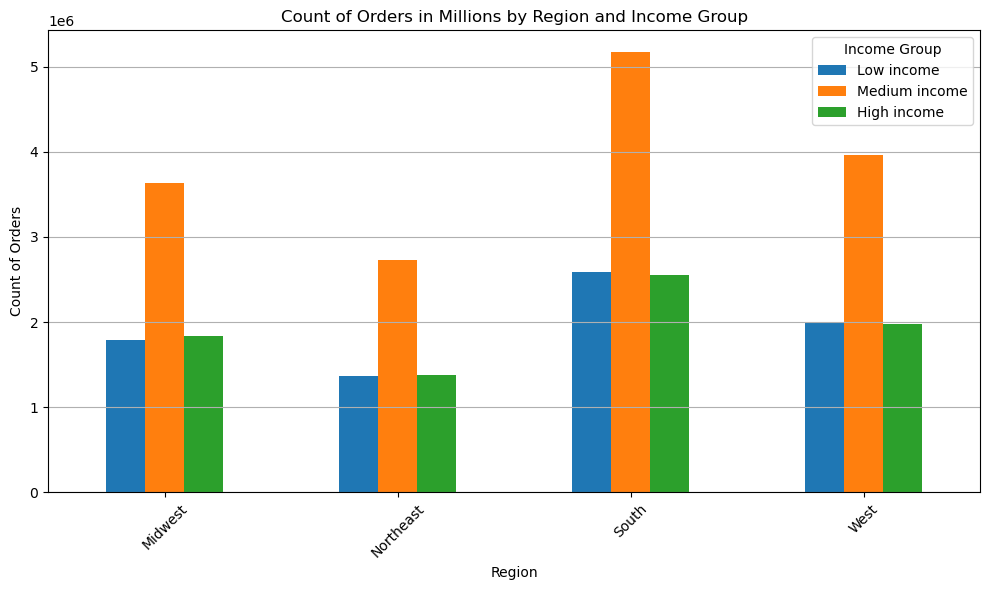

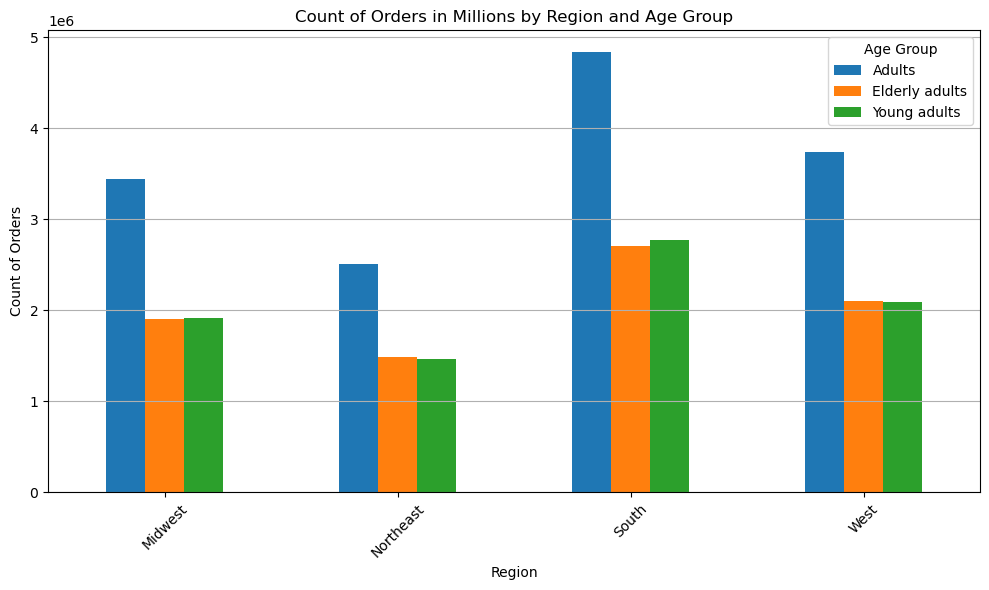

NameError: name 'bar9' is not defined

In [186]:
# Crosstabs for family status, income group, and age group vs regions
# Based on 'order_id'
region_vs_fam_status = pd.crosstab(df_final['region'], df_final['marital_status'], values=df_final['order_id'], aggfunc='count')
region_vs_income_group = pd.crosstab(df_final['region'], df_final['income_group'], values=df_final['order_id'], aggfunc='count')
region_vs_age_group = pd.crosstab(df_final['region'], df_final['age_group'], values=df_final['order_id'], aggfunc='count')

# Define a list of tuples containing the cross-tabulation results and plot titles
plots = [
    (region_vs_fam_status, 'Marital Status', 'Count of Orders in Millions by Region and Family Status', 'region_vs_fam_status.png'),
    (region_vs_income_group, 'Income Group', 'Count of Orders in Millions by Region and Income Group', 'region_vs_income_group.png'),
    (region_vs_age_group, 'Age Group', 'Count of Orders in Millions by Region and Age Group', 'region_vs_age_group.png')
]

# Iterate over the list and create plots for each cross-tabulation
for crosstab, legend_title, title, filename in plots:
    plt.figure(figsize=(10, 6))
    
    # Plot the crosstab data with regions on the x-axis
    crosstab.plot(kind='bar', stacked=False, ax=plt.gca())
    
    plt.title(title)
    plt.xlabel('Region')  # Set the x-axis label to 'Region'
    plt.ylabel('Count of Orders')
    plt.xticks(rotation=45)
    plt.legend(title=legend_title)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()
# Exporting bar chart

bar9.figure.savefig(os.path.join(path, '04 Analysis','Visualizations','count_orders_region_mar_status.png'))

In [190]:
# exporting data to pkl

df_final.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'df_final.pkl'))